In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pprint import pprint
import astropy.units as u
from astropy.units import Quantity
from astropy.table import Table, vstack
from gammapy.spectrum import FluxPoints
from numpy import isnan

# Temporarily fixing environment variable for gamma-cat
import os
os.environ['GAMMA_CAT'] = os.path.join('C:/Users/Arjun/github/gamma-cat')

## The source

3FGL J1709.7-4429

HESS J1708-443

https://github.com/gammasky/fermi-hgps-paper/blob/master/analysis/sources/hgps/pages/HESS_J1708m443.md

In [7]:
# Preparing Fermi data
from gammapy.catalog import SourceCatalog3FGL

cat_f = SourceCatalog3FGL()
source_f = cat_f['3FGL J1709.7-4429']

data_f = source_f.flux_points.table

data_f['e_ref'] = data_f['e_ref'].to('TeV')
data_f['e_min'] = data_f['e_min'].to('TeV')
data_f['e_max'] = data_f['e_max'].to('TeV')

dnde_err_f = data_f['dnde'] * (data_f['flux_errn'] / data_f['flux'])
data_f['dnde_err'] = dnde_err_f.to(data_f['dnde'].unit)

data_f

e_ref,e_min,e_max,flux,flux_errn,flux_errp,eflux,eflux_errn,eflux_errp,is_ul,flux_ul,eflux_ul,dnde,dnde_err
TeV,TeV,TeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),,1 / (cm2 s),erg / (cm2 s),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float32,float32,float32,float32,float32,float32,bool,float64,float64,float64,float64
0.000173205080757,0.0001,0.0003,7.71156e-07,1.10663e-08,1.10663e-08,1.95938e-10,2.81176e-12,2.81176e-12,False,nan,nan,0.00407649738749,5.84987808952e-05
0.000547722557505,0.0003,0.001,4.44454e-07,3.31865e-09,3.31865e-09,3.16203e-10,2.36102e-12,2.36102e-12,False,nan,nan,0.000657860996921,4.91211774692e-06
0.00173205080757,0.001,0.003,1.52146e-07,1.24143e-09,1.24143e-09,3.61055e-10,2.94601e-12,2.94601e-12,False,nan,nan,7.5117655392e-05,6.12917583169e-07
0.00547722557505,0.003,0.01,3.41536e-08,5.17659e-10,5.17659e-10,2.13506e-10,3.23607e-12,3.23607e-12,False,nan,nan,4.44200311617e-06,6.73264697698e-08
0.0316227766017,0.01,0.1,2.50925e-09,1.40578e-10,1.40578e-10,2.32488e-11,1.3025e-12,1.3025e-12,False,nan,nan,1.45107875937e-08,8.12953878448e-10


In [8]:
# Preparing gamma-cat data
from gammapy.catalog import SourceCatalogGammaCat

cat_g = SourceCatalogGammaCat()
source_g = cat_g['HESS J1708-443']

data_g = source_g.flux_points.table
dnde_err_g = data_g['dnde'] * (data_g['dnde_errn'] / data_g['dnde'])
data_g['dnde_err'] = dnde_err_g.to(data_g['dnde'].unit)

data_g

e_ref,dnde,dnde_errp,dnde_errn,dnde_ul,dnde_err
TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float32,float32,float32,float32,float32,float32
0.908,4.13e-12,1.58e-12,1.58e-12,nan,1.58e-12
1.93,1.25e-12,2.35e-13,2.34e-13,nan,2.34e-13
4.14,2.32e-13,5.73e-14,5.71e-14,nan,5.71e-14
8.9,7.82e-14,1.48e-14,1.46e-14,nan,1.46e-14
19.1,8.11e-15,4.3e-15,4.24e-15,nan,4.24e-15


### But I found H.E.S.S. flux points online...

https://www.mpi-hd.mpg.de/hfm/HESS/pages/publications/auxiliary/VelaX_auxinfo.html

Can I find the flux points from 3FGL online as well?

In [9]:
energy_range = [1e-4, 100] * u.TeV
opts = dict(energy_unit='TeV', flux_unit='cm-2 s-1 TeV-1', energy_range=energy_range)

source_f.spectral_model.plot(**opts, color='r', alpha=1)

p_f = source_f.spectral_model.parameters
p_g = source_g.spectral_model.parameters
plt.plot(p_f['reference'].value / 1e6, p_f['amplitude'].value * 1e6, '*', color='c')
plt.plot(p_g['reference'].value, p_g['amplitude'].value, '*', color='c')

fermi = plt.errorbar(x=data_f['e_ref'],
             y = data_f['dnde'],
             yerr = data_f['dnde_err'],
             fmt='.',
             color='g'
            )

hess = plt.errorbar(x=data_g['e_ref'],
             y = data_g['dnde'],
             yerr = data_g['dnde_err'],
             fmt='.',
             color='r'
            )

NotImplementedError: 

In [11]:
# Combining data
colnames=['e_ref', 'dnde', 'dnde_err']

data_combined = vstack([
                    data_f[colnames], 
                    data_g[colnames]
                    ])

flux_points = FluxPoints(data_combined)

flux_points.table

mask = ~np.isnan(flux_points.table['dnde_err'])
flux_points.table = flux_points.table[mask]

flux_points.table

e_ref,dnde,dnde_err
TeV,1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64
0.000173205080757,0.00407649738749,5.84987808952e-05
0.000547722557505,0.000657860996921,4.91211774692e-06
0.00173205080757,7.5117655392e-05,6.12917583169e-07
0.00547722557505,4.44200311617e-06,6.73264697698e-08
0.0316227766017,1.45107875937e-08,8.12953878448e-10
0.907999992371,4.13000016131e-12,1.58000001971e-12
1.92999994755,1.24999999501e-12,2.33999993861e-13
4.13999986649,2.31999993218e-13,5.71000020812e-14


In [12]:
from gammapy.spectrum.models import PowerLaw

class MyChi2:

    def __init__(self, flux_points, spectral_model):
        self.flux_points = flux_points
        self.spectral_model = spectral_model
    
    def __call__(self, amplitude, index):

        t = self.flux_points.table
        
        dnde_model = PowerLaw.evaluate( # Should be calling: spectral_model.evaluate()
            energy=t['e_ref'],
            amplitude=amplitude,
            index=index,
            reference=1 # 1 TeV
        )

        chi = (t['dnde'] - dnde_model) / t['dnde_err']
        return np.sum(chi ** 2)

In [13]:
from iminuit import Minuit

class Chi2Fitter(object):
    def __init__(self, flux_points, spectral_model):
        self.flux_points = flux_points
        self.spectral_model = spectral_model
        self.minuit = None
    
    def fit(self):

        chi2 = MyChi2(self.flux_points, self.spectral_model)
        
        pars = dict(
            amplitude=self.spectral_model.parameters['amplitude'].value,
            index = self.spectral_model.parameters['index'].value
        )
        
        minuit = Minuit(chi2, **pars)
        
        minuit.migrad()
        minuit.hesse()
        
        self.minuit = minuit

In [39]:
spectral_model = PowerLaw(
    reference=2,
    amplitude=1e-14, # p_g['amplitude'].value 
    index=2.0 # p_g['index'].value
)

fitter = Chi2Fitter(flux_points=flux_points, spectral_model=spectral_model)
fitter.fit()

print(fitter.minuit.values)
print('\n', fitter.minuit.errors)


        
fitter.flux_points.table.pprint()

C:\Users\Arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: InitialParamWarning: errordef is not given. Default to 1.
C:\Users\Arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: InitialParamWarning: Parameter amplitude is floating but does not have initial step size. Assume 1.
C:\Users\Arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: InitialParamWarning: Parameter index is floating but does not have initial step size. Assume 1.


FCN = 10203.844830029639 
 TOTAL NCALL = 283 
 NCALLS = 283 
 
 
 EDM = 1.6936948481367358e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,1.7462e-11,3.05116e-13,0,0,,,
2,index,2.28411,0.00230238,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,1.7462e-11,3.05116e-13,0,0,,,
2,index,2.28411,0.00230238,0,0,,,


+,amplitude,index
amplitude,1.00,-0.95
index,-0.95,1.00


{'amplitude': 1.7462023294290905e-11, 'index': 2.2841134962928322}

 {'amplitude': 3.0511599444104814e-13, 'index': 0.0023023804268422084}
      e_ref              dnde            dnde_err    
       TeV         1 / (cm2 s TeV)   1 / (cm2 s TeV) 
----------------- ----------------- -----------------
0.000173205080757  0.00407649738749 5.84987808952e-05
0.000547722557505 0.000657860996921 4.91211774692e-06
 0.00173205080757  7.5117655392e-05 6.12917583169e-07
 0.00547722557505 4.44200311617e-06 6.73264697698e-08
  0.0316227766017 1.45107875937e-08 8.12953878448e-10
   0.907999992371 4.13000016131e-12 1.58000001971e-12
    1.92999994755 1.24999999501e-12 2.33999993861e-13
    4.13999986649 2.31999993218e-13 5.71000020812e-14
    8.89999961853 7.81999993731e-14 1.46000002859e-14
    19.1000003815 8.10999996272e-15 4.24000002385e-15


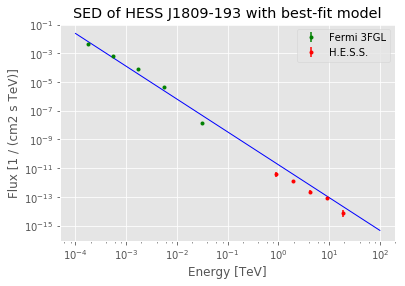

In [40]:
source_g.spectral_model.plot(linestyle='dashed', alpha=0, **opts)
# source_f.spectral_model.plot(linestyle='dashed', alpha=0.7, **opts)

# plt.plot(p_f['reference'].value / 1e6, p_f['amplitude'].value * 1e6, '*', color='g')
# plt.plot(p_g['reference'].value, p_g['amplitude'].value, '*', color='r')

fermi = plt.errorbar(x=data_f['e_ref'],
             y = data_f['dnde'],
             yerr = data_f['dnde_err'],
             fmt='.',
             color='g'
            )

hess = plt.errorbar(x=data_g['e_ref'],
             y = data_g['dnde'],
             yerr = data_g['dnde_err'],
             fmt='.',
             color='r'
            )


from gammapy.utils.energy import Energy
energy = Energy.equal_log_spacing(
    emin=energy_range[0],
    emax=energy_range[1],
    nbins=100,
)

spectral_model = PowerLaw(
    index=fitter.minuit.values['index'],
    amplitude=fitter.minuit.values['amplitude'],
    reference=1
    )

flux = spectral_model(
    energy=energy.to('TeV').value
#     amplitude = fitter.minuit.values['amplitude'],
#     index = fitter.minuit.values['index'],
#     reference=1,
)
plt.plot(energy, flux, linewidth=1, color='blue')

plt.legend([fermi, hess], ['Fermi 3FGL', 'H.E.S.S.'])

plt.title('SED of HESS J1809-193 with best-fit model')

# plt.savefig('test')

In [41]:
print('\nMinimum value of function: ', fitter.minuit.fval)

result = fitter.minuit.fval / (len(flux_points.table) - len(fitter.minuit.args))
print('\nReduced minimum: ', result)


Minimum value of function:  10203.844830029639

Reduced minimum:  1275.4806037537048


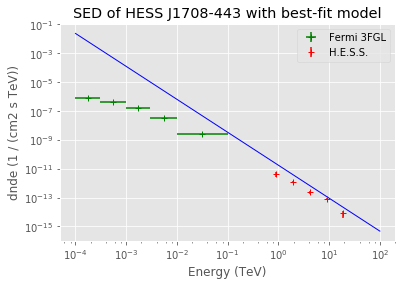

In [46]:
# flux_points.plot(color='g')


source_f.flux_points.plot(color='g')
source_g.flux_points.plot(color='r')

plt.legend(['Fermi 3FGL', 'H.E.S.S.'])

plt.title('SED of HESS J1708-443 with best-fit model')

plt.plot(energy, flux, linewidth=1, color='blue')

# plt.savefig('legend.png')
